In [1]:
#=
tests done on 2 nodes, both running 4 threads; 
1 local i7 2.6 GHz quadcore with hyperthreading running windows and the registry
1 remote 2Ghz i5 dualcore with hyperthreading running linux

Notable is the linux machine burning more computations than the local windows machine. 
Literally burning the CPU into overheating and restarting. Fun.

most significant missing variables are; 
used epsilon, 
variable number of cores(4 per node), 
variable number of nodes (2)

=#
using Gadfly; using DataFrames; using GLM; using Polynomials; using CurveFit; using Optim;


Use "abstract type ApproxFit end" instead.

Use "abstract type LeastSquares<:ApproxFit end" instead.

Use "LinearFit{T}(...) where T" instead.

Use "LogFit{T}(...) where T" instead.

Use "PowerFit{T}(...) where T" instead.

Use "ExpFit{T}(...) where T" instead.


In [2]:
#=
notes about the collected data

SPLIT
the point threshold of a l. 
If over the threshold and the line has a point > epsilon; one of the resulting subcomputions is sent to the workpool.

N
the number of points in the to-be-reduced line

LINE_CONSUMERS; SEARCHERS; SEGMENTS
the ratio between ActiveMQ message consumers; threaded line searchers and the number of search_segments to split a line in

TIME_TAKEN
total runtime for computation in nanoseconds
=#
data = readtable("results-03-06-4152.csv", eltypes=[Int64,Int64,Int64,Int64,Int64,Int64,Int64]);
tail(data)

,nodes,split,n,line_consumers,line_searchers,search_segments,time_taken
1,1,16000,136000,2,2,3,906986392
2,1,64000,136000,2,2,3,353392336
3,1,128000,136000,2,2,3,272712488
4,1,16000,136000,2,2,3,845854470
5,1,64000,136000,2,2,3,346254752
6,1,128000,136000,2,2,3,295135815


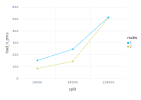

In [3]:
data_means = deepcopy(data)
data_means[:ms_time] = data_means[:time_taken]  / 1000000
data_means[:load_n_pms] = data_means[:n] ./ data_means[:ms_time]

data_means = groupby(data_means, [:nodes, :split]); 
data_means = combine(map(d -> (median(d[:load_n_pms])), data_means))
rename!(data_means, :x1, :load_n_pms )
# color=:split, Scale.color_discrete,
#(data_means[:split].==3000).|(data_means[:split].==4000)
plot(data_means[:,:], x=:split, y=:load_n_pms, color=:nodes, Scale.x_discrete, Scale.color_discrete, Geom.line, Geom.point)

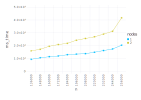

In [4]:
data_means = deepcopy(data)
data_means[:ms_time] = data_means[:time_taken]  / 1000000
data_means[:load_n_pms] = data_means[:n] ./ data_means[:ms_time]

data_means = groupby(data_means, [:nodes, :n]); 
data_means = combine(map(d -> (maximum(d[:ms_time])), data_means))
rename!(data_means, :x1, :ms_time )
# # color=:split, Scale.color_discrete,
# #(data_means[:split].==3000).|(data_means[:split].==4000)
plot(data_means[:,:], x=:n, y=:ms_time, color=:nodes, Scale.x_discrete, Scale.color_discrete, Geom.line, Geom.point)

In [5]:
#=
We have 30 samples for the whole setup, and we take the median to eliminate outliers.
We also convert the time to milliseconds
=#
data_means = groupby(data, [:n,:split,:line_consumers,:line_searchers, :search_segments]); 
data_means = combine(map(d -> median(d[:time_taken]) / 1000000, data_means))
rename!(data_means, :x1, :ms_time )
sort!(data_means, cols=[:ms_time]);
head(data_means)

,n,split,line_consumers,line_searchers,search_segments,ms_time
1,136000,128000,2,2,3,282.8916665
2,148000,128000,2,2,3,290.2870275
3,160000,128000,2,2,3,309.7372505
4,172000,128000,2,2,3,340.038331
5,184000,128000,2,2,3,360.2306955
6,196000,128000,2,2,3,382.171434


In [6]:
#=
keeping SPLIT constant, we can analyze the local optimal line_consumer/line_searcher ratio 
(more line_consumers, especially at higher N's)
=#
searchers_time = deepcopy(data)
searchers_time = by(searchers_time, [:n,:line_searchers], df -> mean(df[:ms_time]))
rename!(searchers_time,:x1, :ms_time_constantsplit)
plot(searchers_time, x=:line_searchers, y=:ms_time_constantsplit, color=:n,Scale.color_discrete, Geom.point, Geom.line, Scale.x_continuous(format=:plain),Scale.y_continuous(format=:plain))


LoadError: [91mKeyError: key :ms_time not found[39m

In [94]:
#=
averaging line_consumers, we can analyze the optimal split threshold
(between 2000 and 8000>, with significant diminishing returns after 2000 at higher N's )
not researched
=#
split_time = deepcopy(data)
split_time = by(split_time, [:n,:split], df -> mean(df[:ms_time]))
rename!(split_time,:x1, :ms_time_constantsearcher)
plot(split_time, x=:split, y=:ms_time_constantsearcher, color=:n,Scale.color_discrete, Geom.point, Geom.line, Scale.x_continuous(format=:plain),Scale.y_continuous(format=:plain))


LoadError: [91mKeyError: key :ms_time not found[39m

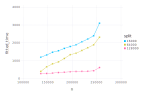

In [95]:
# fitting a polynomial from (N) -> (median_ms) 
function fitting(df)
    model = polyfit(convert(Array, df[:n]), convert(Array, df[:mean_ms]))
    df[:fitted_time] = polyval(model, df[:n])
end

# Pack together the number of consumers and take the mean
# data_poly = groupby(data[(data[:line_searchers].==2),:], [:split,:n]); 
data_poly = groupby(deepcopy(data[:,:]), [:split,:n]); 
data_poly = combine(map(d -> median(d[:time_taken]) / 1000000, data_poly))
rename!(data_poly, :x1, :mean_ms)


data_poly[:fitted_time] = 0.0;
by(data_poly, :split, df -> fitting(df))
plot(data_poly[:, :], x=:n, y=:fitted_time, color=:split, Geom.point, Geom.line, Scale.x_continuous(format=:plain),Scale.color_discrete,Scale.y_continuous(format=:plain))

#=
notes of interest; splitting around 8000 is most efficient,
but there is a case for lower line splitting thresholds at higher N's. 
This probably has a relationship between the number of processing nodes and the split size, but the difference is very sleight and i don't have the nodes to measure.
=#


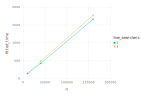

In [284]:
# show log(n) line for various split values


# plot(layer(df_x_500, x=:N, y=:time, Geom.line, Geom.point)
# ,layer(df_x_2000, x=:N, y=:time, Geom.line, Geom.point))
# # layer()

# fit a curve
function fitting(df)
    model = polyfit(convert(Array, df[:n]), convert(Array, df[:mean_ms]))
    df[:fitted_time] = polyval(model, df[:n])
end

# Pack together the number of consumers and take the mean
# data_poly = groupby(data[(data[:line_searchers].==2),:], [:split,:n]); 
data_poly = groupby(data[:,:], [:line_searchers,:n]); 
data_poly = combine(map(d -> mean(d[:time_taken]) / 1000000, data_poly))
rename!(data_poly, :x1, :mean_ms)


data_poly[:fitted_time] = 0.0;
by(data_poly, :line_searchers, df -> fitting(df))
plot(data_poly[:, :], x=:n, y=:fitted_time, color=:line_searchers, Geom.point, Geom.line, Scale.x_continuous(format=:plain),Scale.color_discrete,Scale.y_continuous(format=:plain))

#notes of interest; splitting around 8000 is most efficient, but there is a case for lower line splitting thresholds at higher N's

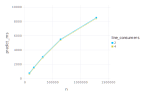

In [306]:
data_poly = deepcopy(data)
data_poly = groupby(data_poly[:,:], [:n]); 
data_poly = combine(map(d -> median(d[:time_taken]), data_poly))
rename!(data_poly, :x1, :mean_ms)
model = polyfit(convert(Array, data_poly[:n]), convert(Array, data_poly[:mean_ms]))

data_poly = deepcopy(data)
data_poly[:polyfit_n] = map((n,actual) -> (actual - polyval(model,n)), data_poly[:n], data_poly[:time_taken])
OLS = glm(@formula(polyfit_n ~ line_consumers + split ), data_poly, Normal(), IdentityLink());


consumers = DataFrame(line_consumers=[1,2,3,4])
splits = DataFrame(split=[1000,2000, 3000, 4000, 5000,6000,7000,8000])
n = DataFrame(n=[80000,160000,320000, 640000,1280000])

dataset = join(consumers, splits, kind = :cross)
dataset = join(dataset, n, kind = :cross)

dataset[:predict_ms] = (predict(OLS, dataset) + polyval(model, dataset[:n])) / 1000000
# n[:modeled] = polyval(model, n[:n])
# plot(n[:, :], x=:n, y=:modeled, Geom.point, Geom.line, Scale.x_continuous(format=:plain),Scale.y_continuous(format=:plain))
# # dataset
# plot(dataset[(dataset[:split].==1000), :], x=:n, y=:predict_ms, color=:line_consumers, Geom.point, Geom.line, Scale.x_continuous(format=:plain),Scale.color_discrete,Scale.y_continuous(format=:plain))
plot(dataset[((dataset[:line_consumers].==2).|(dataset[:line_consumers].==4)).&(dataset[:split].==8000), :], x=:n, y=:predict_ms, color=:line_consumers, Geom.point, Geom.line, Scale.x_continuous(format=:plain),Scale.color_discrete,Scale.y_continuous(format=:plain))

Stacktrace:
 [1] depwarn(::String, ::Symbol) at .\deprecated.jl:70
 [2] log(::Array{Int64,1}) at .\deprecated.jl:57
 [3] log_fit(::Array{Int64,1}, ::Array{Float64,1}) at C:\Users\siege\.julia\v0.6\CurveFit\src\linfit.jl:9
 [4] include_string(::String, ::String) at .\loading.jl:515
 [5] include_string(::Module, ::String, ::String) at C:\Users\siege\.julia\v0.6\Compat\src\Compat.jl:71
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at C:\Users\siege\.julia\v0.6\IJulia\src\execute_request.jl:158
 [7] (::Compat.#inner#17{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at C:\Users\siege\.julia\v0.6\Compat\src\Compat.jl:385
 [8] eventloop(::ZMQ.Socket) at C:\Users\siege\.julia\v0.6\IJulia\src\eventloop.jl:8
 [9] (::IJulia.##14#17)() at .\task.jl:335
while loading In[25], in expression starting on line 6


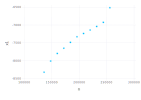

In [25]:
log_n_fit = deepcopy(data)
log_n_fit = groupby(log_n_fit, [:n, :time_taken])
log_n_fit = combine(map(d -> mean(d[:time_taken]) , log_n_fit))
rename!(log_n_fit, :x1, :time_taken_ms)
log_n_fit[:time_taken_ms] = log_n_fit[:time_taken_ms]  ./ 1000000
logfit = log_fit(convert(Array,log_n_fit[:n]),convert(Array,log_n_fit[:time_taken_ms]))
logA = logfit[1]
logB = logfit[2]
function respect(N) return - logA +  end
# time = a + b * log(n)
# 
# log_n_fit[:couple] = respect(log_n_fit[:n])



# logfit
log_n_fit[:linear_time_ms] = -18276 + 1597 * log(log_n_fit[:time_taken_ms])
log_n_fit = groupby(log_n_fit, [:n])
log_n_fit = combine(map(d -> mean(d[:linear_time_ms]) , log_n_fit))
plot(log_n_fit, x=:n, y=:x1, Scale.y_continuous(format=:plain), Scale.x_continuous(format=:plain))